# Generalize support of time-dimensional data

## 

## Including time parameter in wms
### WMS standard
Time in `WMS` standard is considered a dimension of multidimensional data (another might be e.g. elevation) and is described in Annex C of the WMS standard ([1]).
Quoting the standard for publishing the time dimension in GetCapabilities:
>A Dimension element has the following format in XML:
>
>`<Dimension name="dimension_name" units=unit_name unitSymbol="symbol" default="default_value" multipleValues="0|1" nearestValue="0|1" current="0|1">extent</Dimension>`

where the `extent` can have one of the following formats

| Syntax  |  Meaning |
|---|---|
| `value`  | A single value.  |
| `value1,value2,value3,...`  | A list of multiple values.   |
| `min/max/resolution`  | An interval defined by its lower and upper bounds and its resolution.  |
| `min1/max1/res1,min2/max2/res2,...`  | A list of multiple intervals.  |

The time dimension is predefined as follows:

    <Dimension name="time" units="ISO8601" />

Quoting further:

>If a Layer has a Time dimension defined, then requests may include the parameter
>
>    `TIME=value.`
>
>In either case, value uses the format described in Table C.2 to provide a single value, a comma-separated list, or an interval of the form start/end without a resolution. value shall not contain white space. An  interval in a request value is a request for all the data from the start value up to and including the end value. The absence of Time [...] parameters in the request is equivalent to a request for the Layer’s default value (if defined) along that dimension (see C.4.2). All parameter names are case-insensitive as stated in 6.8.1, so, for example, “TIME”, “Time” and “time” are all acceptable. For the TIME parameter, the special keyword “current” may be used if the `<Dimension name="time">` service metadata element includes a nonzero value for the “current” attribute, as described in C.2. The expression “TIME=current” means “send the most current data available”. The expression “TIME=start_time/current” means “send data from start_time up to the most current data available”.


### WMS mapserver config
Mapserver allows for two different approaches to handle time, once as described in the standard via GetCapabilities -- referred to as WMS-T --, once using runtime substituion, where the `&time=YYYY` GET parameter of an HTTP request is parsed and substituted into the DB query.

#### WMS-T
BGDI is using the [WMS-T](https://mapserver.org/ogc/wms_time.html) definition, if the time capability of the layer should be visible in the GetCapabilities file. This is the case e.g. for [ch.bafu.gewaesserschutz-chemischer_zustand_nitrit.map](https://github.com/geoadmin/wms-mapfile_include/blob/master/ch.bafu.gewaesserschutz-chemischer_zustand_nitrit.map) with the following definition
```
    ...
    METADATA
      "wms_enable_request" "*"
      "wms_timeextent" "2011/2015"
      "wms_timeitem" "bgdi_date"
      "wms_timeformat" "YYYY"
      "gml_featureid" "bgdi_id"
      "wms_extent" "2100000 1050000 2850000 1400000"
    END
    ...
```
which produces the following entry in [GetCapabilities](http://wms-bgdi.dev.bgdi.ch/ch.bafu.gewaesserschutz-chemischer_zustand_nitrit/?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities)
```
    ...
    <Dimension name="time" units="ISO8601" nearestValue="0">2011/2015</Dimension>
    ...
```

#### Runtime substitution

Zeitinfo nur für frontend (hidden in getCap with GET parameter runtime substitution: im prinzip reine textoperation)
in mapfile include: (https://github.com/geoadmin/wms-mapfile_include/blob/master/ch.swisstopo.lubis-luftbilder_farbe.map)
```
VALIDATION
        "time" "^[0-9]{8}$"
        "default_time" "99991231"
END
```
=> GET parameter

wms-t (published in getCap): 
requires real date in `bgdi_date`

[1] http://portal.opengeospatial.org/files/?artifact_id=14416


In [21]:
import requests
import xml.etree.ElementTree as ET
from display_xml import XML

# Get Capabilities of wms-t with desired format min/max/res
GetCapUrl = 'https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?service=wms&version=1.3.0&request=GetCapabilities'
resp = requests.get(GetCapUrl)

# register namespaces
namespaces = {
    'd': "http://www.opengis.net/wms",
    'sld': "http://www.opengis.net/sld",
    'xsi': "http://www.w3.org/2001/XMLSchema-instance",
    'ms': "http://mapserver.gis.umn.edu/mapserver"
}
ET.register_namespace('', "http://www.opengis.net/wms")
ET.register_namespace('sld', "http://www.opengis.net/sld")
ET.register_namespace('xsi', "http://www.w3.org/2001/XMLSchema-instance")
ET.register_namespace('ms', "http://mapserver.gis.umn.edu/mapserver")
root = ET.fromstring(resp.text)

# find all Layer nodes that have a child node Dimension in namespace `og` and
# evaluate first one
_l = ''
for layer in root.findall('.//*[d:Dimension]', namespaces):
    _l = ET.tostring(layer, encoding="unicode")
    break
XML(_l)


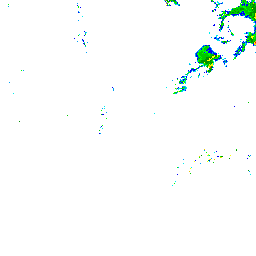

In [17]:
from IPython.core.display import Image, display
# obtain a Map extent at a specific time within the time series
GetMapUrlValid = """https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?
SERVICE=WMS
&VERSION=1.3.0
&REQUEST=GetMap
&FORMAT=image/png
&TRANSPARENT=true
&LAYERS=nexrad-n0r-wmst
&TIME=2019-06-15T15:10:00Z
&WIDTH=256
&HEIGHT=256
&CRS=EPSG:3857
&STYLES=
&BBOX=-12523442.714243278,2504688.542848654,-10018754.171394622,5009377.08569731""".replace('\n','')

resp = requests.get(GetMapUrlValid)

display(Image(data=resp.content, format='jpg', unconfined=True))

In [24]:
import requests
import xml.etree.ElementTree as ET
from display_xml import XML

# the time must be specified down to 5 min, 'daily' aggregates don't make sense and
# result in an error
GetMapUrlInvalid = """https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?
SERVICE=WMS
&VERSION=1.3.0
&REQUEST=GetMap
&FORMAT=image/png
&TRANSPARENT=true
&LAYERS=nexrad-n0r-wmst
&TIME=2019-06-15
&WIDTH=256
&HEIGHT=256
&CRS=EPSG:3857
&STYLES=
&BBOX=-12523442.714243278,2504688.542848654,-10018754.171394622,5009377.08569731""".replace('\n','')

resp = requests.get(GetMapUrlInvalid)
XML(ET.tostring(ET.fromstring(resp.text), encoding="unicode"))

In [ ]:
# https://gibs.earthdata.nasa.gov/wmts/epsg3857/best/wmts.cgi?SERVICE=WMTS&REQUEST=GetCapabilities
# http://globalfloods-ows.ecmwf.int/glofas-ows/ows.py?SERVICE=WMS&request=GetCapabilities